<a href="https://colab.research.google.com/github/dashnak90/mt5_translator/blob/daria/mT5_Translator_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Load libraries and data***

In [1]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 23.5 MB/s 
     |████████████████████████████████| 264 kB 40.9 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.1 MB/s 
     |████████████████████████████████| 636 kB 53.4 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
     |████████████████████████████████| 243 kB 57.9 MB/s 
     |████████████████████████████████| 118 kB 63.9 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import pandas as pd

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mkdir static

In [ ]:
mkdir templates

In [4]:
train_df = pd.read_csv("gdrive/MyDrive/train.tsv", sep="\t", index_col=0).astype(str)
eval_df = pd.read_csv("gdrive/MyDrive/eval.tsv", sep="\t",index_col=0).astype(str)

#train_df["prefix"] = ""
#eval_df["prefix"] = ""

In [5]:
model_repo = 'google/mt5-base'
model_path = '/content/gdrive/My Drive/mt5_translation-3.pt'
max_seq_len = 40

**Load tokenizer and model**

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
# Model description: https://huggingface.co/google/mt5-small
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

**Add prefixes to tokenizer**

In [ ]:
model.config.max_length=40

In [ ]:
len(tokenizer.vocab)

250100

In [7]:
train_df['prefix'].unique()

array(['rus.eng', 'eng.rus', 'ger.eng', 'eng.ger'], dtype=object)

In [8]:
LANG_TOKEN_MAPPING = {
    'rus.eng': '<rus.eng>',
    'eng.rus': '<eng.rus>',
      'ger.eng': '<ger.eng>',
    'eng.ger': '<eng.ger>'
}

In [9]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
special_tokens_dict

{'additional_special_tokens': ['<rus.eng>',
  '<eng.rus>',
  '<ger.eng>',
  '<eng.ger>']}

In [10]:
tokenizer.add_special_tokens(special_tokens_dict)

4

In [11]:
len(tokenizer)

250104

In [12]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>', '<rus.eng>', '<eng.rus>', '<ger.eng>', '<eng.ger>']

In [ ]:
model.config.vocab_size

250112

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(250104, 768)

**Encoding functions**

In [13]:
def encode_str(text, tokenizer, seq_len):  
"""   Tokenize,pad to max length and encode to ids
   Returns tensor with tocken ids"""
  input_ids = tokenizer.encode(
      text=text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

In [15]:
t1=encode_str('<eng.rus> This is a test',tokenizer, max_seq_len)
print(t1)
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

tensor([250101,   1494,    339,    259,    262,   2978,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])
['<eng.rus>', '▁This', '▁is', '▁', 'a', '▁test', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [17]:
t2=encode_str('<rus.eng> тест для конвертации',tokenizer,max_seq_len)
print(t2)
tokens=tokenizer.convert_ids_to_tokens(t2)
print(tokens)

tensor([250100,  17019,    259,    735, 132896,   7547,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])
['<rus.eng>', '▁тест', '▁', 'для', '▁конверт', 'ации', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [34]:
def encode_row(row, tokenizer, seq_len):
  """Encode input and tagret texts from single row"""
  """Returns input and output tensors"""
  input_text = row['input_text']
  target_text = row['target_text']

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_str(
      input_text, tokenizer, seq_len)
  
  target_token_ids = encode_str(
      target_text, tokenizer, seq_len)

  return input_token_ids, target_token_ids


In [27]:
def encode_batch(batch, tokenizer):
  """Encode a single batch"""
  """Returns input and output batch ids"""
  inputs = []
  targets = []
  for index, row in batch.iterrows():
    #gets input and output tocken ids
    formatted_data = encode_row(
        row, tokenizer, max_seq_len)
#    print("i/o tocken ids:",formatted_data)    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    #unsqueeze(input, dim) returns a new tensor with a dimension of size one inserted at the specified position
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
#  print('squeezed tocken ids:',inputs,targets)

#Concatenate the given sequence of seq tensors in the given dimension    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

In [28]:
def data_generator(dataset, tokenizer, batch_size=32):
  """"generates batches"""
  #shuffle the data
  dataset=dataset.sample(frac=1).reset_index(drop=True)

  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield encode_batch(raw_batch, tokenizer)

In [37]:
# Testing data generator
data_gen = data_generator(train_df, tokenizer, 8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)


Input shape: torch.Size([8, 40])
Output shape: torch.Size([8, 40])


**Load the weights (post-training part)**

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**Training**

In [39]:
n_epochs = 1
batch_size = 8
print_freq = 1000
checkpoint_freq = 10000
lr = 5e-4 
n_batches = int(np.ceil(len(train_df) / batch_size)) #number of interations : 100000
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01) 


In [40]:
int(np.ceil(len(train_df) / batch_size))

100000

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
# after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
# Warm up steps is a parameter which is used to lower the learning rate 
# in order to reduce the impact of deviating the model from learning on sudden new data set exposure.
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:
losses = []

In [ ]:
def eval_model(model, dataset, max_iters=10):
  """evaluate the model on small test data"""
  test_generator = data_generator(dataset,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())
    

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # generate batch data
  data_generator = data_generator(train_df,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    #zeroes all the gradients before the calculation
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss
    loss = model_out.loss
    # loss.item() gets the scalar value held in the loss.  item() turns a Tensor into a Python number
    losses.append(loss.item())
    #backpropagation - computing the gradient of the loss function with respect to each weight
    loss.backward()
    # updating weights to minimize loss
    optimizer.step()
    #You call scheduler.step() every batch, right after optimizer.step(), to update the learning rate.
    scheduler.step()

    # Print training update info
    # every 1000 batches
    if (batch_idx + 1) % print_freq == 0:
      #average loss for the last 1000 batches
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    #every 10000 batches save the model 
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, eval_df)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1 | Step: 500 | Avg. loss: 8.420 | lr: 0.00025
Epoch: 1 | Step: 1000 | Avg. loss: 1.914 | lr: 0.0005
Epoch: 1 | Step: 1500 | Avg. loss: 1.704 | lr: 0.0004974747474747475
Epoch: 1 | Step: 2000 | Avg. loss: 1.508 | lr: 0.000494949494949495
Epoch: 1 | Step: 2500 | Avg. loss: 1.480 | lr: 0.0004924242424242425
Epoch: 1 | Step: 3000 | Avg. loss: 1.438 | lr: 0.0004898989898989899
Epoch: 1 | Step: 3500 | Avg. loss: 1.393 | lr: 0.00048737373737373736
Epoch: 1 | Step: 4000 | Avg. loss: 1.370 | lr: 0.0004848484848484849
Epoch: 1 | Step: 4500 | Avg. loss: 1.367 | lr: 0.0004823232323232323
Epoch: 1 | Step: 5000 | Avg. loss: 1.356 | lr: 0.0004797979797979798
Epoch: 1 | Step: 5500 | Avg. loss: 1.335 | lr: 0.0004772727272727273
Epoch: 1 | Step: 6000 | Avg. loss: 1.320 | lr: 0.00047474747474747476
Epoch: 1 | Step: 6500 | Avg. loss: 1.317 | lr: 0.00047222222222222224
Epoch: 1 | Step: 7000 | Avg. loss: 1.289 | lr: 0.0004696969696969697
Epoch: 1 | Step: 7500 | Avg. loss: 1.288 | lr: 0.0004671717171

In [ ]:
import gc
#del model
gc.collect()

torch.cuda.empty_cache()

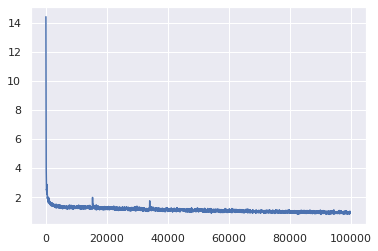

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

**Manual testing**

In [ ]:
test_sentence = eval_df['input_text'].iloc[3]
#test_sentence="<eng.ger> i had an awful meeting with my boss"
print('Raw input text:', test_sentence)

input_ids = encode_str(
    text = test_sentence,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: <eng.rus> He is afraid of dogs.
Truncated input text: <eng.rus> He is afraid of dogs.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, length_penalty = 1, no_repeat_ngram_size=2)
# print(output_tokens)
for token_set in output_tokens:
  print(token_set, tokenizer.decode(token_set,skip_special_tokens=True))

tensor([    0,  5778,  2758,  4013, 55141,   260,     1,     0],
       device='cuda:0') Он боится собак.
tensor([    0,  5778,  2758,  4013, 55141,   279,   260,     1],
       device='cuda:0') Он боится собаки.
tensor([    0,  5778, 74061,  7990, 55141,   260,     1,     0],
       device='cuda:0') Он опасается собак.


In [ ]:

!pip install sacrebleu
import sacrebleu

     |████████████████████████████████| 54 kB 2.4 MB/s 


**English-Russian**

In [ ]:
russian_truth = [eval_df.loc[eval_df["prefix"] == "eng.rus"]["target_text"].tolist()]


In [ ]:
russian_truth = russian_truth[0][:500]

In [ ]:
to_russian=eval_df.loc[eval_df["prefix"] == "eng.rus"]["input_text"].tolist()

In [ ]:
to_russian=to_russian[:500]

In [ ]:
russian_preds=[]
for i in to_russian:
  input_ids = encode_str(
    text = i,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
  input_ids = input_ids.unsqueeze(0).cuda()
  #print(input_ids)
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
  for token_set in output_tokens:
    russian_preds.append(tokenizer.decode(token_set, skip_special_tokens=True))

In [ ]:
len(russian_preds), len(russian_truth)

(500, 500)

In [ ]:
russian_preds[0], russian_truth[0]

('Я не могу объяснить это тебе.', 'Я не в состоянии тебе это объяснить.')

In [ ]:
eng_rus_bleu = sacrebleu.corpus_bleu(russian_preds, [russian_truth])
print("--------------------------")
print("English to Russian: ", eng_rus_bleu.score)

--------------------------
English to Russian:  27.746710980637296


**Russian-English**

In [ ]:
english_truth = [eval_df.loc[eval_df["prefix"] == "rus.eng"]["target_text"].tolist()]


In [ ]:
english_truth = english_truth[0][:500]

In [ ]:
to_english=eval_df.loc[eval_df["prefix"] == "rus.eng"]["input_text"].tolist()

In [ ]:
to_english=to_english[:500]

In [ ]:
english_preds=[]
for i in to_english:
  input_ids = encode_str(
    text = i,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
  input_ids = input_ids.unsqueeze(0).cuda()
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
  for token_set in output_tokens:
    english_preds.append(tokenizer.decode(token_set, skip_special_tokens=True))

In [ ]:
rus_eng_bleu = sacrebleu.corpus_bleu(english_preds, [english_truth])


In [ ]:
print("--------------------------")
print("Russian to English: ", rus_eng_bleu.score)

--------------------------
Russian to English:  43.594575147451685


**German-English**

In [ ]:
english_truth = [eval_df.loc[eval_df["prefix"] == "ger.eng"]["target_text"].tolist()]
to_english=eval_df.loc[eval_df["prefix"] == "ger.eng"]["input_text"].tolist()


In [ ]:
english_truth = english_truth[0][:500]
to_english=to_english[:500]

In [ ]:
english_preds=[]
for i in to_english:
  input_ids = encode_str(
    text = i,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
  input_ids = input_ids.unsqueeze(0).cuda()
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
  for token_set in output_tokens:
    english_preds.append(tokenizer.decode(token_set, skip_special_tokens=True))

In [ ]:
ger_eng_bleu = sacrebleu.corpus_bleu(english_preds, [english_truth])
print("--------------------------")
print("German to English: ", ger_eng_bleu.score)

--------------------------
German to English:  41.93287864627209


**English-German**

In [ ]:
german_truth = [eval_df.loc[eval_df["prefix"] == "eng.ger"]["target_text"].tolist()]
to_german=eval_df.loc[eval_df["prefix"] == "eng.ger"]["input_text"].tolist()

In [ ]:
german_truth = german_truth[0][:500]
to_german=to_german[:500]

In [ ]:
german_preds=[]
for i in to_german:
  input_ids = encode_str(
    text = i,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
  input_ids = input_ids.unsqueeze(0).cuda()
  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
  for token_set in output_tokens:
    german_preds.append(tokenizer.decode(token_set, skip_special_tokens=True))

In [ ]:
eng_ger_bleu = sacrebleu.corpus_bleu(german_preds, [german_truth])
print("--------------------------")
print("English to German: ", eng_ger_bleu.score)

--------------------------
English to German:  32.375929786580215


In [ ]:
#@title Translator
input_text = 'Last night I had a very bad experience.' #@param {type:"string"}
output_language = '\u003Ceng.ger>' #@param ["<ger.eng>", "<eng.ger>", "<eng.rus>","<rus.eng>"]

input_ids = encode_input_str(
    text = output_language+input_text,
    tokenizer = tokenizer,
    seq_len = model.config.max_length
    )
input_ids = input_ids.unsqueeze(0).cuda()
print(input_ids)
output_tokens = model.generate(input_ids,num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

tensor([[250103,   6460,   9713,    336,   1425,    259,    262,    259,   2364,
           6201,   4842,    260,      1,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')
Last night I had a very bad experience.  ->  letzte Nacht hatte ich eine sehr schlechte Erfahrung.


**Flask App**

requires upload to templates and static folders

In [ ]:
!pip install flask-ngrok



In [ ]:

from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)   


@app.route('/')
def index():
    
    return render_template('index.html', title='Welcome  to  mT5-Translator')

@app.route('/translate',methods=["POST"])
def translate():
    input = dict(request.form)
 

    TEXT=list(input.values())[1]
    FROM=list(input.keys())[0]
    TO=list(input.keys())[2]



    input_text = str(TEXT)
    language = '<'+str(FROM)+'>'
    print(language,input_text)
    input_ids = encode_str(
        text = language+input_text,
        tokenizer = tokenizer,
        seq_len = max_seq_len
        )
    input_ids = input_ids.unsqueeze(0).cuda()
    print(input_ids)
    output_tokens = model.generate(input_ids,num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
    
    TRANS=tokenizer.decode(output_tokens[0], skip_special_tokens=True)
#    TRANS='your translation'


    return render_template('translate.html', text=input_text, trans=TRANS )
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://5e52cc5b8d01.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Aug/2021 13:27:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/image3.gif HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/google2.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:17] "GET /static/google.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:18] "GET /favicon.ico HTTP/1.1" 404 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:09] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:09] "GET /static/unnamed.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:18] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:25] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:34] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:48] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:43:00] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:43:07] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:43:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:45:48] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:06] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:14] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:19] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:25] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:31] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:36] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:42] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:59:15] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:08:29] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:08:39] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:08:47] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:08:54] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:09:01] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:09:09] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:09:19] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:09:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:19:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:19:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:23:12] "GET / HTTP/1.1" 200 -


<eng.ger> Please specify desired languages and enter your text


tensor([[250103,    259,   9560, 104488,    276,  44776,    345,    259, 100568,
            305,  21548,    772,   7461,    259,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:23:23] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:23:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:26:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:33:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:33:13] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:46:39] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:46:53] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:47:00] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:47:11] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:47:21] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:47:29] "GET / HTTP/1.1" 200 -
